In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 9.4 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from keras.layers import Dense, Dropout, Input, BatchNormalization, Activation, DepthwiseConv2D, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Add, Concatenate, Reshape
from keras.models import Model
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
import random
import shutil
import zipfile
from google.colab.patches import cv2_imshow

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
def relu6(x):
  return min(max(0, x), 6)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def conv_bn(input, filters, kernel_size = (3, 3), strides = 1, padding = "same", kernel_initializer = "he_normal", batch_norm = True):
  x = Conv2D(filters = filters, kernel_size = (kernel_size[0], kernel_size[1]), strides = strides, padding = padding, kernel_initializer = kernel_initializer)(input)
  if batch_norm:
    x = BatchNormalization()(x)
  return x

In [ ]:
def reduction_block(input, filters_3, filters_1, padding = "same", kernel_initializer = "he_normal", pool_size = (3, 3)):
  # y_init = conv_bn(input, filters_1, (1, 1), strides = 1, padding = padding, kernel_initializer = kernel_initializer, batch_norm = False)
  # y = LeakyReLU(alpha=0.3)(y_init)
  input_channel = input.shape[3]
  y = conv_bn(input, input_channel, (3, 3), strides = 2, padding = padding, kernel_initializer = kernel_initializer)
  y = Activation("relu")(y)
  z = MaxPooling2D(pool_size = pool_size, padding = "same", strides = 2)(input)
  z = Activation("relu")(z)
  z = Add()([y, z])
  
  y = conv_bn(z, filters_1, (1, 1), strides = 1, padding = padding, kernel_initializer = kernel_initializer)
  y = Activation("relu")(y)


  #print(y.shape, z.shape)

  # return Add()([y, z])
  return y

In [ ]:
def squeeze_excitation(input, reduction_ratio = 8):
  batch_size, breadth, height, channels = input.shape
  #print(batch_size, breadth, height, channels)
  x = GlobalAveragePooling2D()(input)
  x = Flatten()(x)
  x = Dense(channels//reduction_ratio, activation = "relu")(x)
  # x = BatchNormalization()(x)
  #if include_dropout:
  #x = Dropout(dropout_num)(x)
  x = Dense(channels, activation = "sigmoid")(x)
  # x = BatchNormalization()(x)
  # x = conv_bn(x, channels//reduction_ratio, (1, 1), padding = "valid")
  # x = conv_bn(x, channels, (1, 1), padding = "valid")
  x = Reshape((1, 1, x.shape[1]))(x)
  # print(f"x shape: {x.shape}")
  # print(f"y shape: {y.shape}")
  x = input * x

  return Add()([input, x])

In [ ]:
def fused_MB_conv(input, filters):
  '''Fused MB Conv is a type of residual block that uses Relu6 activation. Here we don't have depthwise conv separately so no need to omit activation function
     as was discussed in Xceptionet paper'''

  x = conv_bn(input, 4*filters, (3, 3), strides = 1)
  x = Activation("relu")(x)
  x = squeeze_excitation(x)
  x = Activation("relu")(x)
  x = conv_bn(x, filters, (1, 1), strides=1)
  x = Activation("relu")(x)

  return Add()([input, x])

In [ ]:
def inception(input, filter_1, filter_5, filter_3, last_layer = False):
  input_filter = input.shape[3]
  a = conv_bn(input, filter_1, (1, 1))
  a = Activation("relu")(a)

  b = conv_bn(input, filter_5, (1, 1))
  b = Activation("relu")(b)
  if not last_layer:
    b = conv_bn(b, filter_5, (5, 5))
  else:
    b = conv_bn(b, filter_5, (3, 3))
    b = conv_bn(b, filter_5, (3, 3))
  b = Activation("relu")(b)

  c = conv_bn(input, filter_3//2, (1, 1))
  c = Activation("relu")(c)
  c = conv_bn(c, filter_3, (3, 3))
  c = Activation("relu")(c)

  res = Concatenate()([a, b, c])
  res = conv_bn(res, input_filter, (1, 1))
  res = Activation("relu")(res)
  
  return Add()([res, input])

In [ ]:
def MB_conv(input, filters, initial_layer = False):
  '''MB Conv is a type of residual block that uses Relu or "no" activation. Here we do depthwise conv '''

  x = conv_bn(input, 4*filters, (1, 1), strides = 1)
  x = Activation("relu")(x)
  x = DepthwiseConv2D((3, 3), strides = 1, padding = "same", depthwise_initializer="he_normal")(x)
  if not initial_layer:
    x = Activation("relu")(x)
  x = BatchNormalization()(x)
  x = squeeze_excitation(x)
  if not initial_layer:
    x = Activation("relu")(x)
  x = conv_bn(x, filters, (1, 1), strides=1)
  x = Activation("relu")(x)

  return Add()([input, x])

In [ ]:
# def inception_reduction(input, filter_1, filter_3, filter_5, pool_size = (3,3)):
#   a = AveragePooling2D(pool_size = pool_size, padding = "same", strides = 2)(input)
#   a = conv_bn(a, filter_1, (1, 1))
#   a = Activation("relu")(a)

#   b = conv_bn(input, 256, (1, 1))
#   b = Activation("relu")(b)
#   b = DepthwiseConv2D((3, 3), strides = 2, padding = "same", depthwise_initializer="he_normal")(b)
#   b = Activation("relu")(b)

#   c = conv_bn(input, 128, (1, 1))
#   c = Activation("relu")(c)
#   c = DepthwiseConv2D((5, 5), strides = 2, padding = "same", depthwise_initializer="he_normal")(c)
#   c = Activation("relu")(c)

#   # d = conv_bn(input, 64, (1, 1))
#   # d = Activation("relu")(d)
#   # d = conv_bn(d, filter_3_2, (3, 3), strides = 2)
#   # d = Activation("relu")(d)

#   return Concatenate()([a, b, c])

def inception_reduction(input, filter_1, filter_3, filter_5, pool_size = (3,3)):
  a = AveragePooling2D(pool_size = pool_size, padding = "same", strides = 2)(input)
  a = conv_bn(a, filter_1, (1, 1))
  a = Activation("relu")(a)

  b = conv_bn(input, 128, (1, 1))
  b = Activation("relu")(b)
  b = conv_bn(b, filter_3, (1, 3), strides = 2)
  b = Activation("relu")(b)
  b = conv_bn(b, filter_3, (3, 1))
  b = Activation("relu")(b)

  c = conv_bn(input, 96, (1, 1))
  c = Activation("relu")(c)
  c = conv_bn(c, filter_5, (1, 5), strides = 2)
  c = Activation("relu")(c)
  c = conv_bn(c, filter_5, (5, 1))
  c = Activation("relu")(c)

  # d = conv_bn(input, 64, (1, 1))
  # d = Activation("relu")(d)
  # d = conv_bn(d, filter_3_2, (3, 3), strides = 2)
  # d = Activation("relu")(d)

  return Concatenate()([a, b, c])

# Model building

In [ ]:
input = Input(shape = (160, 160, 3))
x = BatchNormalization()(input)

x = conv_bn(x, 32, (3, 3), strides = 2)
x = Activation("relu")(x)
x = conv_bn(x, 64, (3, 3), strides = 1)
x = Activation("relu")(x)

x = reduction_block(x, 64, 64)
x = Activation("relu")(x)

# x = fused_MB_conv(x, 64)
# x = Activation("relu")(x)
# x = fused_MB_conv(x, 64)
# x = Activation("relu")(x)
x = inception(x, 64, 32, 64)
x = Activation("relu")(x)
x = MB_conv(x, 64, True)
x = Activation("relu")(x)


x = reduction_block(x, 128, 128)
x = Activation("relu")(x)

x = inception(x, 64, 32, 64)
x = Activation("relu")(x)
x = MB_conv(x, 128, True)
x = Activation("relu")(x)

x = reduction_block(x, 192, 192)
x = Activation("relu")(x)

x = inception(x, 96, 64, 96)
x = Activation("relu")(x)
x = MB_conv(x, 192)
x = Activation("relu")(x)

x = reduction_block(x, 256, 256)
x = Activation("relu")(x)

x = inception(x, 128, 64, 128)
x = Activation("relu")(x)
x = MB_conv(x, 256)
x = Activation("relu")(x)

x = inception_reduction(x, 128, 256, 128)
x = Activation("relu")(x)
output1 = GlobalAveragePooling2D()(x)

x = inception(x, 256, 128, 192, last_layer = True)
x = Activation("relu")(x)
x = squeeze_excitation(x)
output2 = GlobalAveragePooling2D()(x)

final_output = Concatenate()([output1, output2])

x = Dropout(0.2)(x)
x = Dense(128, activation = "relu")(final_output)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(32, activation = "relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1, "sigmoid")(x)

In [ ]:
model = Model(inputs = input, outputs = x)
model.summary()

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Data loading

In [ ]:
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

In [ ]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/DFD/kaggle.json ~/.kaggle/
!kaggle datasets download -d in8mare/dfd-train
zip_ref = zipfile.ZipFile("/content/dfd-train.zip", 'r')
zip_ref.extractall('/content') 
zip_ref.close()
os.makedirs("/content/Train Data")

 99% 766M/777M [00:06<00:00, 139MB/s]
100% 777M/777M [00:07<00:00, 116MB/s]


In [ ]:
!kaggle datasets download -d in8mare/dfd-val
zip_ref = zipfile.ZipFile("/content/dfd-val.zip", 'r')
zip_ref.extractall('/content') 
zip_ref.close()
os.makedirs("/content/Val Data")

 87% 87.0M/100M [00:00<00:00, 154MB/s]
100% 100M/100M [00:00<00:00, 124MB/s] 


In [ ]:
shutil.rmtree("/content/Train_Deepfake")
shutil.rmtree("/content/Train_Real")

In [ ]:
shutil.rmtree("/content/Val_Deepfake")
shutil.rmtree("/content/Val_Real")

In [ ]:
!kaggle datasets download -d in8mare/dfd-test-data
zip_ref = zipfile.ZipFile("/content/dfd-test-data.zip", 'r')
zip_ref.extractall('/content') 
zip_ref.close()
os.makedirs("/content/Test Data")

 92% 91.0M/99.1M [00:00<00:00, 118MB/s]
100% 99.1M/99.1M [00:00<00:00, 125MB/s]


In [ ]:
shutil.rmtree("/content/Deepfake")
shutil.rmtree("/content/Real")

In [ ]:
!kaggle datasets download -d in8mare/dfd-train-org 
zip_ref = zipfile.ZipFile("/content/dfd-train-org.zip", 'r')
zip_ref.extractall('/content') 
zip_ref.close()
os.makedirs("/content/Train_Data")

100% 158M/158M [00:01<00:00, 98.2MB/s]
100% 158M/158M [00:01<00:00, 105MB/s] 


In [ ]:
import albumentations as A
transform = A.Compose([
      A.OneOf([
        A.Rotate(limit=360, interpolation=1, border_mode=4, always_apply=False, p=0.65),
        A.Rotate(limit=360, interpolation=1, border_mode=0, always_apply=False, p=0.35),
      ], p = 0.9), 

      A.OneOf([
        A.Affine(scale = 1.4, translate_percent= None,shear = None, p=0.5),
        A.Affine(scale = None,translate_percent= 0.1, shear = None, p=0.25),
        A.Affine(scale = None,translate_percent= None,shear = (10,10), p=0.25), 
      ], p = 0.4),
], p=0.8)

In [ ]:
root_dir = "/content/Train_Data/Deepfake/"
os.makedirs("/content/deepfake")
os.chdir("/content/deepfake")
COUNT = 1
for file in os.listdir(root_dir):
  img = plt.imread(root_dir + file)
  for i in range(2):
    image = transform(image = img)["image"]
    cv2.imwrite(f"/content/deepfake/orgdeepfake_{COUNT}.jpg", image)
    COUNT+=1 
print(COUNT)

root_dir = "/content/Train_Data/Real/"
os.makedirs("/content/real")
os.chdir("/content/real")
COUNT = 1
for file in os.listdir(root_dir):
  img = plt.imread(root_dir + file)
  image = transform(image = img)["image"]
  cv2.imwrite(f"/content/real/orgreal_{COUNT}.jpg", image)
  COUNT+=1 
print(COUNT)

8401
10001


In [ ]:
root_dir = "/content/deepfake"
i = 1
files = os.listdir(root_dir)
random.shuffle(files)
for img in files:
  if i<=1000:
    shutil.copy(root_dir + "/" + img, "/content/Val Data/Deepfake")
  else:
    shutil.copy(root_dir + "/" + img, "/content/Train Data/Deepfake")
  i+=1

root_dir = "/content/real"
files = os.listdir(root_dir)
random.shuffle(files)
i = 1
for img in files:
  if i<=1500:
    shutil.copy(root_dir + "/" + img, "/content/Val Data/Real")
  else:
    shutil.copy(root_dir + "/" + img, "/content/Train Data/Real")
  i+=1

In [ ]:
shutil.rmtree("/content/Deepfake")
shutil.rmtree("/content/Real")
shutil.rmtree("/content/Train_Data")

In [ ]:
root_dir = "/content/Val Data/Deepfake"
files = os.listdir(root_dir)
random.shuffle(files)
for img in files:
  shutil.copy(root_dir + "/" + img, "/content/Train Data/Deepfake")

root_dir = "/content/Val Data/Real"
files = os.listdir(root_dir)
random.shuffle(files)
for img in files:
  shutil.copy(root_dir + "/" + img, "/content/Train Data/Real")

In [ ]:
shutil.rmtree("/content/Val Data")
shutil.rmtree("/content/deepfake")
shutil.rmtree("/content/real")

In [ ]:
files = os.listdir("/content/Train Data")
print(files)
try:
  shutil.rmtree("/content/Train Data/.ipynb_checkpoints")
except:
  pass
files = os.listdir("/content/Train Data")
print(files)

files = os.listdir("/content/Test Data")
print(files)
try:
  shutil.rmtree("/content/Test Data/.ipynb_checkpoints")
except:
  pass
files = os.listdir("/content/Test Data")
print(files)

['Real', 'Deepfake']
['Real', 'Deepfake']
['Real', 'Deepfake']
['Real', 'Deepfake']


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory = '/content/Train Data',
    labels='inferred',
    label_mode = 'int',
    batch_size=64,
    image_size=(160,160),
    shuffle = True,
    seed = 0
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    directory = '/content/Test Data',
    labels='inferred',
    label_mode = 'int',
    batch_size = 64,
    image_size=(160,160),
    shuffle = True,
    seed = 0
)

def preprocess(image, label):
  image = tf.cast(image, tf.float32)
  image = image/255.0
  return image, label

train_ds = train_ds.map(preprocess)
validation_ds = validation_ds.map(preprocess)


AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.prefetch(buffer_size=AUTOTUNE)

Found 72356 files belonging to 2 classes.
Found 5996 files belonging to 2 classes.


#New Model

In [ ]:
new_model = Model(inputs = input, outputs = x)
# new_model.summary()

In [ ]:
# new_model = tf.keras.models.load_model("/content/drive/MyDrive/DFD/DFD new/custom_cnn_latest.h5")

In [ ]:
N_EPOCHS = 10
VERBOSE=1 
LR_MAX = 0.000004
WD_RATIO = 1

N_WARMUP_EPOCHS = 0

In [ ]:
import math
# Learning rate scheduler with logaritmic warmup and cosine decay / exponential decay
def lrfn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=N_EPOCHS):
    
    if current_step < num_warmup_steps:
        return lr_max * 0.10 ** (num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))

        # return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max
        k = 0.5
        return lr_max * math.exp(-k*progress*current_step)

In [ ]:
# Tensorflow Learning Rate Scheduler does not update weight decay, need to do it manually in a custom callback
class WeightDecayCallback(tf.keras.callbacks.Callback):
    def __init__(self, wd_ratio=WD_RATIO):
        self.step_counter = 0
        self.wd_ratio = wd_ratio
    
    def on_epoch_begin(self, epoch, logs=None):
        new_model.optimizer.weight_decay = new_model.optimizer.learning_rate * self.wd_ratio
        print(f'learning rate: {new_model.optimizer.learning_rate.numpy():.2e}, weight decay: {new_model.optimizer.weight_decay.numpy():.2e}')

In [ ]:
# We will use the famous AdamW optimizer for fast learning with weight decay
optimizer = tfa.optimizers.AdamW(learning_rate=LR_MAX, weight_decay=WD_RATIO*LR_MAX, epsilon=1e-6)
# optimizer = tfa.optimizers.AdamW(learning_rate=0.0001, weight_decay=0.00005, epsilon=1e-6)
# Loss
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

# Metrics
metrics = ['accuracy']

new_model.load_weights("/content/drive/MyDrive/DFD/latest_model_stats-05-0.92.hdf5")
# new_model.load_weights("/content/drive/MyDrive/model_stats-01-0.77.hdf5")

new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# Learning Rate 
# Learning rate for encoder
LR_SCHEDULE = [lrfn(step, num_warmup_steps=N_WARMUP_EPOCHS, lr_max=LR_MAX, num_cycles=0.50) for step in range(N_EPOCHS)]
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=0)

In [ ]:
COUNT = 5

In [ ]:
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
filepath = "/content/latest_model_stats-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose = 1, save_best_only = True, mode = 'max')
log_csv = CSVLogger(f'/content/latest_logs_{COUNT}.csv', separator = ',', append = False)
earlystop = EarlyStopping(monitor = "val_accuracy", patience = 3, verbose = 1, min_delta = 0.001)
callbacks_list = [checkpoint, log_csv, lr_callback,earlystop, WeightDecayCallback()]  
# callbacks_list = [checkpoint, log_csv, earlystop]
COUNT+=1

In [ ]:
new_model.fit(train_ds, validation_data = validation_ds, epochs = N_EPOCHS, verbose = 1, callbacks = callbacks_list)

learning rate: 4.00e-06, weight decay: 4.00e-06
Epoch 1/10
1131/1131 [==============================] - ETA: 0s - loss: 0.1092 - accuracy: 0.9643
Epoch 1: val_accuracy improved from -inf to 0.91478, saving model to /content/latest_model_stats-01-0.91.hdf5
1131/1131 [==============================] - 294s 236ms/step - loss: 0.1092 - accuracy: 0.9643 - val_loss: 0.2329 - val_accuracy: 0.9148 - lr: 4.0000e-06
learning rate: 3.80e-06, weight decay: 3.80e-06
Epoch 2/10
1131/1131 [==============================] - ETA: 0s - loss: 0.1073 - accuracy: 0.9656
Epoch 2: val_accuracy did not improve from 0.91478
1131/1131 [==============================] - 263s 232ms/step - loss: 0.1073 - accuracy: 0.9656 - val_loss: 0.2319 - val_accuracy: 0.9146 - lr: 3.8049e-06
learning rate: 3.27e-06, weight decay: 3.27e-06
Epoch 3/10
1131/1131 [==============================] - ETA: 0s - loss: 0.1052 - accuracy: 0.9672
Epoch 3: val_accuracy did not improve from 0.91478
1131/1131 [==============================]

KeyboardInterrupt: ignored

In [ ]:
new_model.evaluate(validation_ds)

94/94 [==============================] - 20s 96ms/step - loss: 58.9725 - accuracy: 0.9246


[58.972530364990234, 0.9246163964271545]

# Adding ML classifier

In [ ]:
def get_intermediate_model(model, last_layer_name: str):
  layer_output = model.get_layer(last_layer_name).output
  intermediate_model = tf.keras.models.Model(inputs=model.input,outputs=layer_output)
  return intermediate_model

In [ ]:
new_model.summary()

In [ ]:
intermediate_model = get_intermediate_model(new_model, "flatten_4")  #change

In [ ]:
new_inp = intermediate_model.input
x = Dropout(0.6)(intermediate_model.output)
x = Dense(1000, activation = "relu")(x)
x = Dropout(0.6)(x)
x = Dense(1, activation = "sigmoid")(x)
new_out = x
new_model = tf.keras.models.Model(inputs=new_inp,outputs=x)

In [ ]:
new_model.summary()

In [ ]:
new_model.fit(train_ds, validation_data = validation_ds, epochs = N_EPOCHS, verbose = 1, callbacks = callbacks_list)

learning rate: 1.00e-04, weight decay: 1.00e-04
Epoch 1/10
1131/1131 [==============================] - ETA: 0s - loss: 0.1757 - accuracy: 0.9289
Epoch 1: val_accuracy improved from -inf to 0.90460, saving model to /content/model_stats-01-0.90.hdf5
1131/1131 [==============================] - 271s 218ms/step - loss: 0.1757 - accuracy: 0.9289 - val_loss: 0.2191 - val_accuracy: 0.9046 - lr: 1.0000e-04
learning rate: 9.75e-05, weight decay: 9.75e-05
Epoch 2/10
1131/1131 [==============================] - ETA: 0s - loss: 0.1379 - accuracy: 0.9446
Epoch 2: val_accuracy did not improve from 0.90460
1131/1131 [==============================] - 244s 215ms/step - loss: 0.1379 - accuracy: 0.9446 - val_loss: 0.2306 - val_accuracy: 0.9029 - lr: 9.7531e-05
learning rate: 9.51e-05, weight decay: 9.51e-05
Epoch 3/10
1131/1131 [==============================] - ETA: 0s - loss: 0.1196 - accuracy: 0.9529
Epoch 3: val_accuracy improved from 0.90460 to 0.90994, saving model to /content/model_stats-03-0.91

#### Training a SGDClassifier which is by default linear SVM

In [ ]:
new_model.load_weights("/content/drive/MyDrive/DFD/1000_layer_model_stats-05-0.92.hdf5")

In [ ]:
intermediate_model = get_intermediate_model(new_model, "dense_11")  #change

In [ ]:
from sklearn.linear_model import SGDClassifier
import random
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
clf = SGDClassifier() # by default loss is hinge so it is an linear svm

cur_features = []
cur_y_train = []
i=1
for img_batch, label_batch in train_ds:
  features = intermediate_model.predict(img_batch)
  cur_features.append(features)
  cur_y_train.append(label_batch)

  if i%131==0:
    cur_features = np.array(cur_features, dtype='float32')
    cur_features = cur_features.reshape(-1, cur_features.shape[2])
    cur_y_train = np.array(cur_y_train, dtype = 'int')
    cur_y_train = np.concatenate([item for item in cur_y_train], axis = 0)
    # cur_features = scaler.fit_transform(cur_features)
    clf.partial_fit(cur_features, cur_y_train, classes = np.unique(cur_y_train))
    cur_features = []
    cur_y_train = []
  
  if i==1310:
    break

  i+=1

In [ ]:
del cur_features
del cur_y_train

In [ ]:
new_model.save("/content/1000_layer_output_model.h5")

In [ ]:
cur_features = []
cur_y_test = []
i = 1
for img_batch, label_batch in validation_ds:
  features = intermediate_model.predict(img_batch)
  cur_features.append(features)
  cur_y_test.append(label_batch)
  if i==93:
    break
  i+=1

cur_features = np.array(cur_features, dtype='float32')
cur_features = cur_features.reshape(-1, cur_features.shape[2])
cur_y_test = np.array(cur_y_test, dtype = 'int')
cur_y_test = np.concatenate([item for item in cur_y_test], axis = 0)

In [ ]:
# SVM
pred_svm = clf.predict(cur_features)
from sklearn.metrics import classification_report
report_svm = classification_report(cur_y_test, pred_svm)
print(report_svm)

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      2973
           1       0.92      0.92      0.92      2979

    accuracy                           0.92      5952
   macro avg       0.92      0.92      0.92      5952
weighted avg       0.92      0.92      0.92      5952



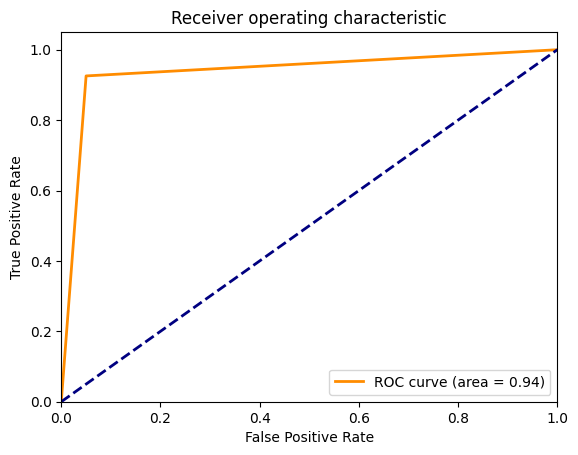

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(cur_y_test, pred_svm)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [ ]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

#### Saving the SVM model

In [ ]:
import joblib
filename = '/content/temp_svm_1000_output_model.sav'
joblib.dump(clf, filename)

['/content/temp_svm_1000_output_model.sav']

In [ ]:
# load the model from disk
import joblib
clf = joblib.load("/content/drive/MyDrive/DFD/temp_svm_1000_output_model.sav")  #change filename
# result = loaded_model.score(X_test, Y_test) #change
# print(result)

### Trying XGBoost model 

In [ ]:
import xgboost as xgb

cur_features = []
cur_y_train = []
i=1
model = None
params = {
    "eta" : 0.1,
    "max_depth" : 10,
    "tree_method" : "gpu_hist",
    "predictor" : "gpu_predictor"
}
for img_batch, label_batch in train_ds:
  features = intermediate_model.predict(img_batch)
  cur_features.append(features)
  cur_y_train.append(label_batch)

  if i%154==0: #154
    cur_features = np.array(cur_features, dtype='float32')
    cur_features = cur_features.reshape(-1, cur_features.shape[2])
    cur_y_train = np.array(cur_y_train, dtype = 'int')
    cur_y_train = np.concatenate([item for item in cur_y_train], axis = 0)
    dtrain = xgb.DMatrix(cur_features, cur_y_train)
    model = xgb.train(params, dtrain, xgb_model=model)
    cur_features = []
    cur_y_train = []
  
  if i==924:  #924
    break

  i+=1

In [ ]:
cur_features = []
cur_y_test = []
i = 1
for img_batch, label_batch in validation_ds:
  features = intermediate_model.predict(img_batch)
  cur_features.append(features)
  cur_y_test.append(label_batch)
  if i==140: #break
    break
  i+=1

cur_features = np.array(cur_features, dtype='float32')
cur_features = cur_features.reshape(-1, cur_features.shape[2])
cur_y_test = np.array(cur_y_test, dtype = 'int')
cur_y_test = np.concatenate([item for item in cur_y_test], axis = 0)

In [ ]:
pred_xgb = model.predict(xgb.DMatrix(cur_features))
pred_xgb = np.where(pred_xgb > 0.5, 1, 0)
# pred_xgb = xgb.predict(cur_features)
from sklearn.metrics import classification_report
report_xgb = classification_report(cur_y_test, pred_xgb)
print(report_xgb)

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      3979
           1       0.94      0.95      0.95      4981

    accuracy                           0.94      8960
   macro avg       0.94      0.94      0.94      8960
weighted avg       0.94      0.94      0.94      8960



In [ ]:
final_features = []
y_train = []

for img_batch, label_batch in train_ds:
  features = intermediate_model.predict(img_batch)
  final_features.append(features)
  y_train.append(label_batch)

    
final_features = np.array(final_features, dtype='float32') #total no. of images must be multiple of 32
y_train = np.array(y_train, dtype = 'int')
final_features = final_features.reshape(-1, final_features.shape[2])
y_train = np.concatenate([item for item in y_train], axis = 0)
final_features.shape

In [ ]:
# Training XGBoost model
import xgboost as xgb
xgb_model = xgb.XGBClassifier()
xgb_model.fit(final_features, y_train)

In [ ]:
# Training a SVM model
from sklearn.svm import SVC 
svm = SVC(kernel = 'linear', C=0.1)
svm.fit(final_features, y_train)

In [ ]:
# Training Random Forest model
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(final_features, y_train)

In [ ]:
# Training Logistic Regression model
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(final_features, y_train)

In [ ]:
del final_features
del y_train

In [ ]:
test_final_features = []
y_test = []

for img_batch, label_batch in validation_ds:
  features = intermediate_model.predict(img_batch)
  test_final_features.append(features)
  y_test.append(label_batch)

test_final_features = np.array(test_final_features, dtype='float32')
y_test = np.array(y_test, dtype = 'int')
test_final_features = test_final_features.reshape(-1, test_final_features.shape[2])
y_test = np.concatenate([item for item in y_test], axis = 0)
test_final_features.shape

In [ ]:
pred_xgb = xgb_model.predict(test_final_features)
from sklearn.metrics import classification_report
report_xgb = classification_report(y_test, pred_xgb)
print(report_xgb)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, pred_xgb)
sns.heatmap(cm, annot=True)

In [ ]:
# SVM
pred_svm = svm.predict(test_final_features)
from sklearn.metrics import classification_report
report_svm = classification_report(y_test, pred_svm)
print(report_svm)

In [ ]:
# Random Forest
pred_rfc = rfc.predict(test_final_features)
from sklearn.metrics import classification_report
report_rfc = classification_report(y_test, pred_rfc)
print(report_rfc)

In [ ]:
# LR
pred_lr = lr.predict(test_final_features)
from sklearn.metrics import classification_report
report_lr = classification_report(y_test, pred_lr)
print(report_lr)

### Trying out GridSearch CV

In [ ]:
# Training a SVM model
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC 
svc= SVC()
parameters = {
    "kernel": ["linear","rbf"],
    "C":[0.1,1,10]
}

cv = GridSearchCV(svc,parameters,cv=5)
cv.fit(final_features,y_train) 

In [ ]:
print(cv.best_params_)
print(cv.best_score_)
print(cv.best_estimator_)

### Testing on "Actual Test data" provided by competition

In [ ]:
os.makedirs("/content/Test Data/Deepfake")
os.makedirs("/content/Test Data/Real")

In [ ]:
root_dir = "/content/drive/MyDrive/Omdena DeepFake Image Detection (preprocessed data)/Test_Dataset/test-task1"
test_real = "/content/Test Data/Real"
test_deepfake = "/content/Test Data/Deepfake"
i = 0
with open("/content/labels.txt", "r") as file:
  label = file.readlines()
  for path in os.listdir(root_dir):
    if label[i][0] == '1':
      shutil.copy(root_dir + "/" + path,test_deepfake)
    else:
      shutil.copy(root_dir + "/" + path, test_real)
    i+=1

print(len(os.listdir(test_real)), len(os.listdir(test_deepfake))) 

2000 5000


In [ ]:
test_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/Test Data',
    labels='inferred',
    label_mode = 'int',
    batch_size=64,
    image_size=(160,160),
    shuffle = True,
    seed = 0
)

def preprocess(image, label):
  image = tf.cast(image, tf.float32)
  image = image/255.0
  return image, label

test_ds = test_ds.map(preprocess)


AUTOTUNE = tf.data.AUTOTUNE

test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Found 7000 files belonging to 2 classes.


In [ ]:
new_model.evaluate(test_ds)

110/110 [==============================] - 30s 149ms/step - loss: 1.4025 - accuracy: 0.6274


[1.4024773836135864, 0.6274285912513733]

In [ ]:
cur_features = []
cur_y_test = []
i = 1
for img_batch, label_batch in test_ds:
  features = new_model.predict(img_batch)
  features[features >=0.6] = 1
  features[features < 0.6] = 0
  cur_features.append(features)
  cur_y_test.append(label_batch)
  if i==109:
    break
  i+=1

cur_features = np.array(cur_features, dtype='float32')
cur_features = cur_features.reshape(-1, cur_features.shape[2])
cur_y_test = np.array(cur_y_test, dtype = 'int')
cur_y_test = np.concatenate([item for item in cur_y_test], axis = 0)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(cur_y_test, cur_features))

              precision    recall  f1-score   support

           0       0.74      0.75      0.75      4985
           1       0.35      0.34      0.35      1991

    accuracy                           0.63      6976
   macro avg       0.55      0.55      0.55      6976
weighted avg       0.63      0.63      0.63      6976



In [ ]:
# SVM
pred_svm = clf.predict(cur_features)
from sklearn.metrics import classification_report
report_svm = classification_report(cur_y_test, pred_svm)
print(report_svm)

              precision    recall  f1-score   support

           0       0.74      0.73      0.74      4985
           1       0.35      0.36      0.35      1991

    accuracy                           0.63      6976
   macro avg       0.55      0.55      0.55      6976
weighted avg       0.63      0.63      0.63      6976



### Seeing which images it is misclassifying

In [ ]:
model = Model(inputs = input, outputs = x)
model.load_weights("/content/drive/MyDrive/DFD/lil_model_stats-01-0.95.hdf5")
# model.compile(optimizer=optimizer, loss=loss, metrics=metrics)